In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from datetime import datetime
import seaborn as sns
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
class RemoveFirstFrame(BaseEstimator, TransformerMixin):
    def __init__(self, frame):
        self.frame = frame
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.query(f"Step % {frame} != 1")
def choose_top_rw(data,n=5):
    return data.assign(chosen=pd.DataFrame.rank(data.Rw, method='first')<=n)
def choose_top_vtotal(data,n=5):
    return data.assign(chosen=pd.DataFrame.rank(data.VTotal, method='first')<=n)
def choose_top(data,col="Qw", n=5, ascending=False):
    return data.assign(chosen=pd.DataFrame.rank(data[col], ascending=ascending, method='first')<=n)

In [6]:
raw_test_data = pd.read_csv("/Users/weilu/Research/data/test_data/complete_data_mar27.csv", index_col=0)

In [8]:
raw_test_data["Name"].unique()

array(['1MBA', 'T0792', 'T0815', 'T0766', 'T0784', 'T0803', 'T0833',
       'T0251'], dtype=object)

In [9]:
FEATURES = ['Rw',
#      'VTotal',
     'QGO',
     'VwithoutGo',
#      'Burial',
#      'Water',
#      'Rama',
#      'DSSP',
#      'P_AP',
#      'Helix',
#      'Frag_Mem'
               ]
n = 5
def my_transform(data, label, degree, FEATURES=FEATURES):

    # LABEL = "Qw"
    LABEL = label
    PolynomialDegree = degree

    num_attribs = FEATURES
    cat_attribs = [LABEL]
    num_pipeline = Pipeline([
            ('selector', DataFrameSelector(num_attribs)),
            ('std_scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
        ])
    cat_pipeline = Pipeline([
            ('selector', DataFrameSelector(cat_attribs))
        ])

    full_pipeline = FeatureUnion(transformer_list=[
            ("num_pipeline", num_pipeline),
            ("cat_pipeline", cat_pipeline),
        ])
    return full_pipeline.fit_transform(data)

def my_transform_predict(data, degree, FEATURES=FEATURES):

    # LABEL = "Qw"
    PolynomialDegree = degree

    num_attribs = FEATURES
    num_pipeline = Pipeline([
            ('selector', DataFrameSelector(num_attribs)),
            ('std_scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
        ])
    return num_pipeline.fit_transform(data)

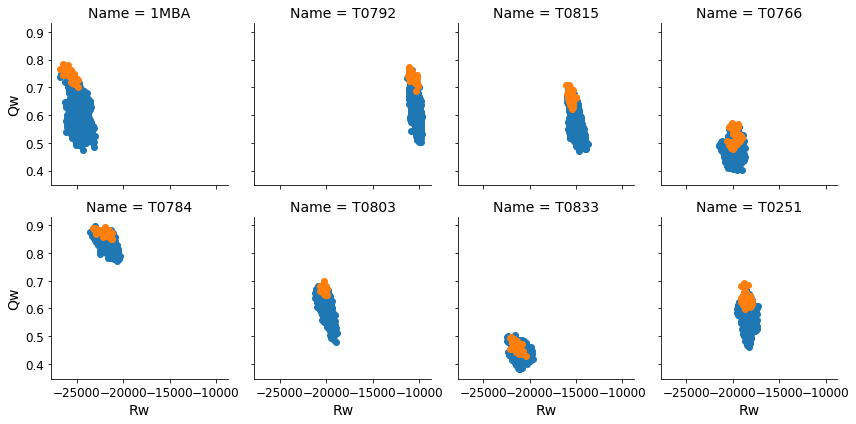

In [10]:
g = sns.FacetGrid(raw_test_data, col="Name", hue="isGood", col_wrap=4)
g = g.map(plt.scatter, "Rw", "Qw")

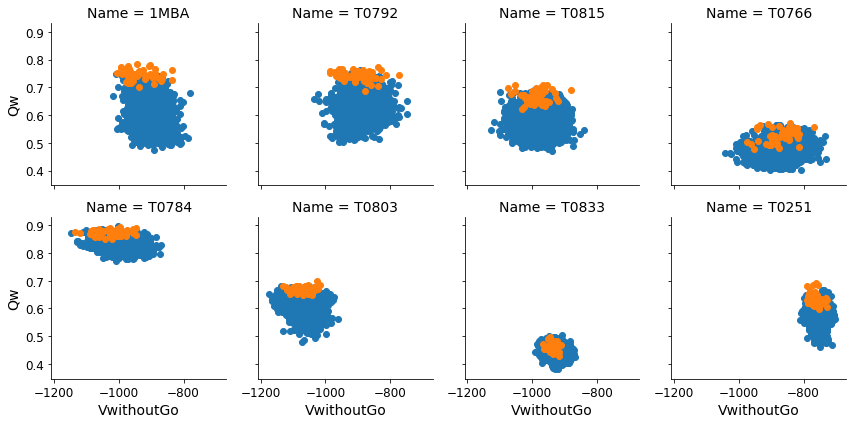

In [11]:
g = sns.FacetGrid(raw_test_data, col="Name", hue="isGood", col_wrap=4)
g = g.map(plt.scatter, "VwithoutGo", "Qw")

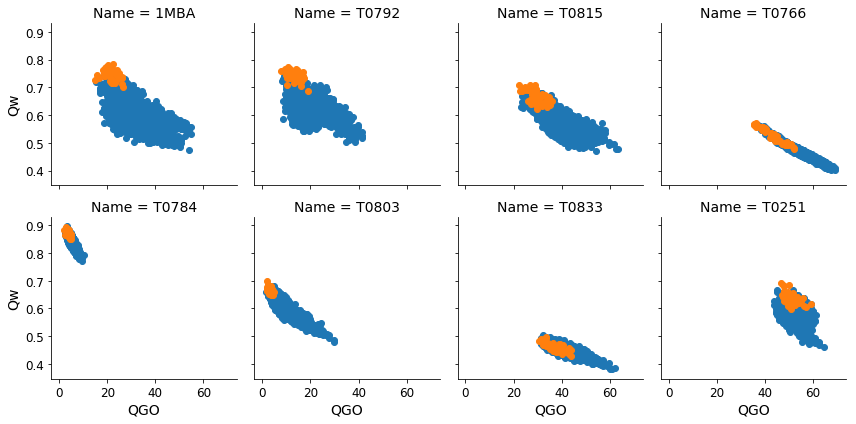

In [12]:
g = sns.FacetGrid(raw_test_data, col="Name", hue="isGood", col_wrap=4)
g = g.map(plt.scatter, "QGO", "Qw")

In [13]:
raw_data_T0784 = raw_test_data.groupby("Name").get_group("T0784")
# raw_data_T0792 = raw_test_data.groupby("Name").get_group("T0792")
# raw_data = pd.concat([raw_data_T0784, raw_data_T0792])
# raw_data = raw_data_T0792
# raw_data = raw_test_data.groupby("Name").get_group("1mba")
raw_data = raw_data_T0784

In [14]:
# FEATURES = ["Rw", "VTotal", "QGO"]
# FEATURES = ["Rw", "VTotal", "QGO", "Burial", "Frag_Mem", "Water"]
# FEATURES = list(raw_test_data.columns[2:-3])
def train_and_test(raw_data, label="Qw", degree=1, p=0.1):
    # my_full_pipeline = Pipeline([
    # #         ('removeFirstFrame', RemoveFirstFrame(frame)),
    #         ('featureSelection', full_pipeline)
    # ])

    from sklearn.model_selection import StratifiedShuffleSplit

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=142)
    for train_index, test_index in split.split(raw_data, raw_data["isGood"]):
        strat_train_set = raw_data.iloc[train_index]
        strat_test_set = raw_data.iloc[test_index]
    # strat_test_set[LABEL].value_counts() / len(strat_test_set)
    X_train = my_transform(strat_train_set, label, degree)
    X_test = my_transform(strat_test_set, label, degree)
    train_y = X_train[:,-1]
    train_set = X_train[:,:-1]
    test_y = X_test[:,-1]
    test_set = X_test[:,:-1]
    return (train_set, train_y, test_set, test_y)

In [15]:
label = "isGood"
degree = 1
p = 0.1
train_set, train_y, test_set, test_y = train_and_test(raw_data, label=label, degree=degree)
log_clf = LogisticRegression(random_state=140, penalty='l2')

# log_clf = LogisticRegression(random_state=14, class_weight={0:p, 1:(1-p)}, penalty='l1')
log_clf.fit(train_set, train_y)
y_pred = log_clf.predict(train_set)
# n = 100
prediction_list = []
for name, data in raw_test_data.groupby("Name"):
    print(name)
#     X = full_pipeline.fit_transform(data)
    X = my_transform(data, label, degree)
    eval_y = X[:,-1]
    eval_set = X[:,:-1]
    test= log_clf.predict_proba(eval_set)[:,1]
    one = data.assign(prediction=test)
    prediction_list.append(one)
#     prediction_list.append(pd.Series(test))
t = pd.concat(prediction_list)
# t = raw_test_data.assign(prediction=prediction.values)
best_by_prediction = t.groupby("Name").apply(choose_top, n=n, col="prediction").query("chosen==True")

1MBA
T0251
T0766
T0784
T0792
T0803
T0815
T0833


In [68]:
a = best_by_prediction.reset_index(drop=True)[["Name", "Qw", "GDT", "Rmsd", "prediction", "Step"]].groupby("Name").apply(lambda x: x.sort_values("prediction", ascending=False))

In [69]:
a

Name        Qw      GDT      Rmsd  prediction  Step
Name                                                          
1MBA  0    1MBA  0.720428  74.8275   2.46068    0.306414   110
      2    1MBA  0.769650  78.4275   2.17425    0.295674   186
      3    1MBA  0.764916  76.2000   2.32998    0.259163   189
      4    1MBA  0.765128  77.9100   2.13531    0.258174   200
      1    1MBA  0.774211  78.5975   2.05417    0.251528   154
T0251 5   T0251  0.613264  66.4375   3.36632    0.490454   606
      7   T0251  0.598274  65.0475   4.07155    0.392429  1086
      8   T0251  0.589351  62.5000   3.84180    0.383658  1214
      9   T0251  0.598703  66.6700   3.66330    0.368319  1643
      6   T0251  0.625360  68.2875   3.41842    0.362572   807
T0766 10  T0766  0.563178  65.7425  11.67540    0.554039   203
      14  T0766  0.567218  63.4250  11.26950    0.511339  1813
      11  T0766  0.558608  61.8075  10.93520    0.473008  1534
      12  T0766  0.559387  59.7200  11.08980    0.469498  1538
      13  T0766  0.555598  62.2700  11.06980    0.461466  1542
T0784 17  T0784  0.882307  92.2000   1.62316    0.627947   857
      15  T0784  0.880859  89.6000   1.75722    0.506263   831
      16  T0784  0.872920  89.4000   1.77279    0.446581   837
      18  T0784  0.867933  90.2000   1.60258    0.438664   865
      19  T0784  0.876679  89.8000   1.58467    0.404382  1376
T0792 21  T0792  0.760305  81.2500   2.56529    0.235421   178
      22  T0792  0.764793  82.1875   2.62657    0.216476   179
      24  T0792  0.721099  75.6250   2.60695    0.203726   201
      23  T0792  0.724748  78.4375   2.72955    0.202526   184
      20  T0792  0.734884  77.8125   2.71745    0.187593   167
T0803 26  T0803  0.652454  72.9500   5.56915    0.118500  1610
      27  T0803  0.651672  72.5750   5.43667    0.116946  1643
      29  T0803  0.669025  74.8150   5.16925    0.116922  1866
      28  T0803  0.667617  72.0150   5.74664    0.107859  1776
      25  T0803  0.668172  76.1200   5.37375    0.107811  1466
T0815 31  T0815  0.707513  75.9425   2.79595    0.505570   412
      34  T0815  0.688493  75.0000   3.02543    0.426500  1017
      32  T0815  0.696955  74.7625   2.91935    0.418012   413
      30  T0815  0.670086  72.6425   3.05629    0.393732   405
      33  T0815  0.687528  73.5875   2.75682    0.375505   414
T0833 35  T0833  0.481112  46.0650   7.85891    0.384751  1086
      39  T0833  0.500173  45.1425   7.93678    0.352314  1598
      38  T0833  0.491663  46.9950   7.94893    0.350031  1566
      36  T0833  0.489800  44.4475   7.90148    0.327418  1093
      37  T0833  0.464509  43.7500   7.65779    0.311368  1099

In [65]:
best_by_prediction

Burial       Chain        Chi       DSSP    Frag_Mem  \
Name                                                                    
1MBA  108   -124.242780  158.855236  30.323929  -0.000002 -302.743939   
      152   -126.243786  176.912295  29.712160  -0.000000 -322.480824   
      184   -124.634118  169.489180  30.350727  -0.000000 -329.377988   
      187   -125.781771  181.579885  36.539224  -0.000000 -316.739048   
      198   -121.494717  170.322420  47.135640  -0.000000 -336.985619   
T0251 14601  -95.329584    0.000000   0.000000 -18.948112 -168.256806   
      14801  -95.303688    0.000000   0.000000 -19.236927 -163.179403   
      15079  -94.987749    0.000000   0.000000 -19.560253 -177.489653   
      15206  -94.390840    0.000000   0.000000 -16.066872 -180.670345   
      15633  -96.000242    0.000000   0.000000 -16.076913 -177.203630   
T0766 6200  -112.624465  188.325481  30.895513 -49.008378 -469.802983   
      7525  -111.417309  166.218859  32.328037 -46.302119 -469.499556   
      7529  -112.539366  187.068071  35.553058 -45.208302 -469.903807   
      7533  -110.545408  167.216823  30.508533 -41.168442 -445.476486   
      7802  -110.327038  188.886410  44.613638 -46.060935 -482.736497   
T0784 8825  -130.839383  214.863201  47.986716 -62.634052 -473.757952   
      8831  -131.490523  242.672681  42.504205 -66.122428 -479.780696   
      8851  -132.585918  199.884006  36.975969 -65.359975 -462.829356   
      8859  -130.816541  225.360574  39.524157 -66.920459 -483.529636   
      9368  -130.716504  182.594835  44.706046 -63.925670 -430.386684   
T0792 2165   -68.845464    0.000000   0.000000 -11.679158 -138.922046   
      2176   -68.383185    0.000000   0.000000 -12.333798 -151.635991   
      2177   -66.829633    0.000000   0.000000 -12.324533 -136.244804   
      2182   -66.764212    0.000000   0.000000 -11.379303 -142.648547   
      2199   -67.291334    0.000000   0.000000 -11.763105 -138.461736   
T0803 11457 -115.849649    0.000000   0.000000 -16.823276 -460.244209   
      11600 -117.789174    0.000000   0.000000 -16.990047 -518.257762   
      11633 -115.697321    0.000000   0.000000 -13.745015 -502.367349   
      11766 -113.242257    0.000000   0.000000 -17.548841 -455.850190   
      11855 -115.883113    0.000000   0.000000 -17.259622 -449.272054   
T0815 4401   -91.132568    0.000000   0.000000 -47.497515 -132.351116   
      4408   -92.193956    0.000000   0.000000 -46.772515 -130.432221   
      4409   -91.029138    0.000000   0.000000 -46.831771 -126.794659   
      4410   -91.217226    0.000000   0.000000 -47.890374 -132.376990   
      5010   -90.381384    0.000000   0.000000 -42.235888 -136.192054   
T0833 13079 -114.669302    0.000000   0.000000 -73.822987 -171.109036   
      13086 -116.972607    0.000000   0.000000 -70.184939 -163.257791   
      13092 -116.011856    0.000000   0.000000 -77.184370 -164.526959   
      13557 -118.435360    0.000000   0.000000 -64.133283 -182.506228   
      13589 -117.131893    0.000000   0.000000 -68.895468 -181.859193   

                 GDT      Helix   Name       P_AP        QGO   ...    \
Name                                                           ...     
1MBA  108    74.8275 -51.621281   1MBA  -4.705667  15.175482   ...     
      152    78.5975 -50.214701   1MBA  -5.810129  19.575829   ...     
      184    78.4275 -56.175641   1MBA  -7.274706  18.903284   ...     
      187    76.2000 -54.489866   1MBA  -7.759328  19.712599   ...     
      198    77.9100 -53.332677   1MBA  -7.588980  19.545050   ...     
T0251 14601  66.4375 -13.515449  T0251 -11.006397  43.924477   ...     
      14801  68.2875 -11.442570  T0251 -13.478508  43.812953   ...     
      15079  65.0475 -10.094889  T0251 -13.630907  45.275842   ...     
      15206  62.5000 -13.459546  T0251 -13.017631  44.848086   ...     
      15633  66.6700 -11.997696  T0251 -12.017146  44.820247   ...     
T0766 6200   65.7425  -8.579221  T0766 -21.102260  35.470681   ...     
      7525   6

In [16]:
print(*(zip(FEATURES, log_clf.coef_[0])))

('Rw', -0.19232275270600122) ('QGO', -1.6223111058603839) ('VwithoutGo', -0.28966535406693028)


In [17]:
n = 5
chosen_by_rw = raw_test_data.groupby("Name").apply(choose_top_rw, n)
chosen_by_vtotal = raw_test_data.groupby("Name").apply(choose_top_vtotal, n)
chosen_by_qgo = raw_test_data.groupby("Name").apply(choose_top, n=n, col="QGO", ascending=True)
top_rw = chosen_by_rw.query("chosen==True")
top_vtotal = chosen_by_vtotal.query("chosen==True")
top_qgo = chosen_by_qgo.query("chosen==True")

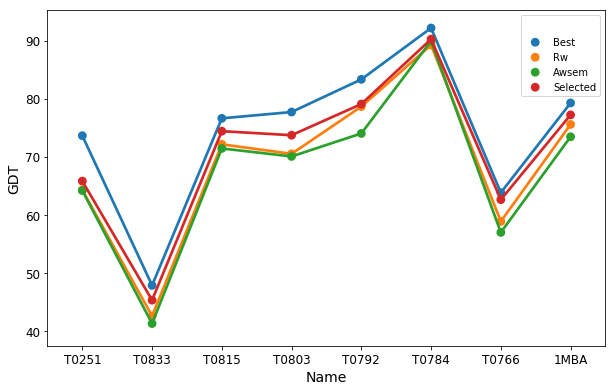

In [22]:
# T0784
label = "GDT"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Selected"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
final3 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["Selected"]], axis=1).melt(id_vars="Name", value_name=label, var_name=" ")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
order = ["T0251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name", label, data=final3, hue=" ", errwidth=0, order=order)
plt.savefig("/Users/weilu/Desktop/fig6_GDT.png", dpi=300)
# plt.ylim([0.4,1])
final_gdt = final3

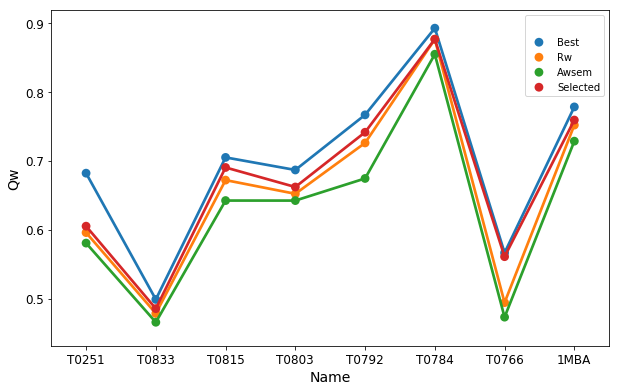

In [23]:
# T0784
label = "Qw"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Selected"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
final3 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["Selected"]], axis=1).melt(id_vars="Name", value_name=label, var_name=" ")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
order = ["T0251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name", label, data=final3, hue=" ", errwidth=0, order=order)
plt.savefig("/Users/weilu/Desktop/fig6_Qw.png", dpi=300)
# plt.ylim([0.4,1])
final_Qw = final3

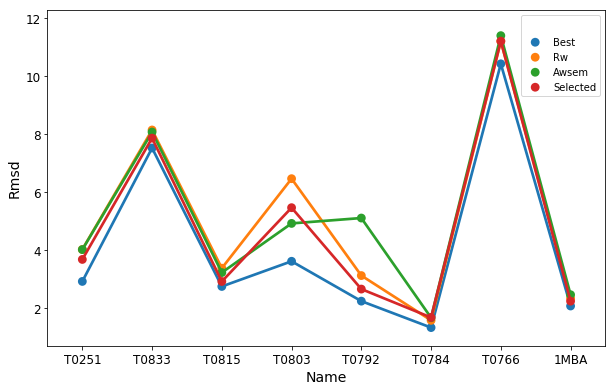

In [24]:
# T0784
label = "Rmsd"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label, ascending=True).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Selected"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
final3 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["Selected"]], axis=1).melt(id_vars="Name", value_name=label, var_name=" ")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
order = ["T0251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name", label, data=final3, hue=" ", errwidth=0, order=order)
plt.savefig("/Users/weilu/Desktop/fig6_Rmsd.png", dpi=300)
# plt.ylim([0.4,1])
final_Rmsd = final3

In [32]:
final = pd.concat([final_gdt, final_Qw["Qw"], final_Rmsd["Rmsd"]], axis=1)

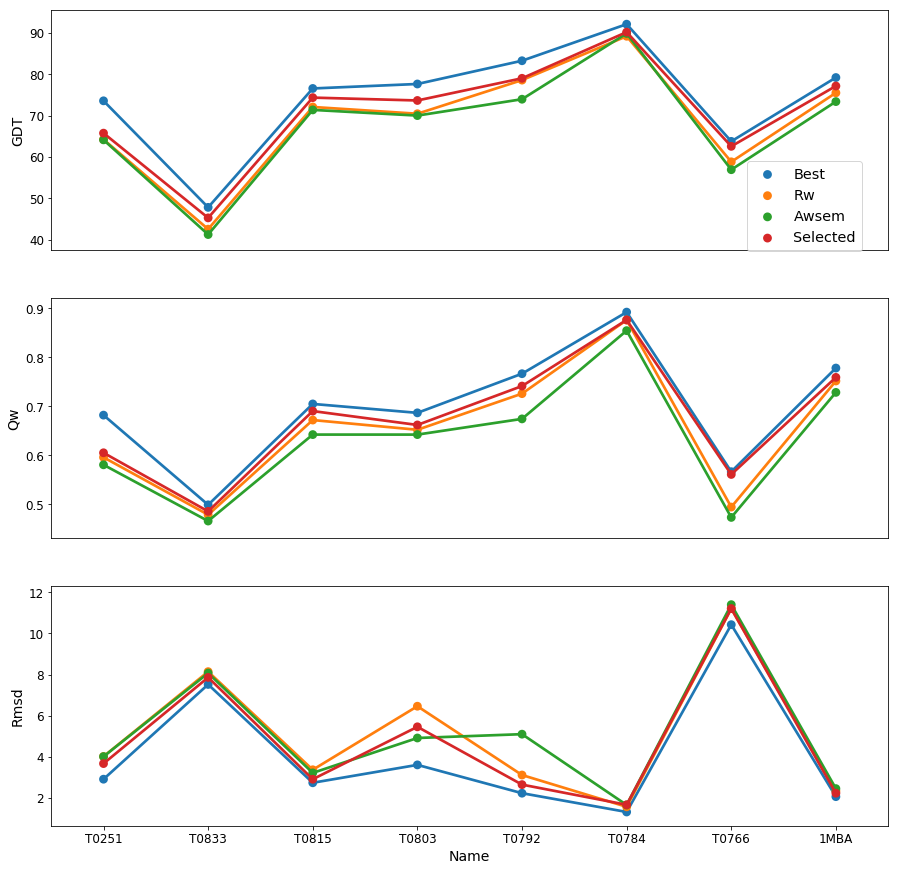

In [64]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(15,15))
sns.pointplot("Name", "GDT", data=final, hue=" ", errwidth=0, order=order, ax=ax1)
ax1.legend_.remove()
ax1.get_xaxis().set_visible(False)
sns.pointplot("Name", "Qw", data=final, hue=" ", errwidth=0, order=order, ax=ax2)
ax2.legend_.remove()
ax2.get_xaxis().set_visible(False)
sns.pointplot("Name", "Rmsd", data=final, hue=" ", errwidth=0, order=order, ax=ax3)
plt.legend(loc=9, bbox_to_anchor=(0.9, 2.8), ncol=1, fontsize='x-large')
plt.savefig("/Users/weilu/Desktop/fig6.png", dpi=300)